# Setup


In [1]:
# Installing required directories

!pip install opendatasets

import os
import random
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import opendatasets as od
import pandas
from collections import Counter

od.download("https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda")

Skipping, found downloaded files in "./animal-image-datasetdog-cat-and-panda" (use force=True to force download)


In [2]:
TRAIN_DIR = '/content/animal-image-datasetdog-cat-and-panda/animals/animals'
CATEGORIES = []
for c in os.listdir(TRAIN_DIR):
    CATEGORIES.append(c)
print(CATEGORIES)

['dogs', 'panda', 'cats']


In [4]:
TRAIN_DATA = []
IMG_SIZE = 32
for c in CATEGORIES:
    path = os.path.join(TRAIN_DIR,c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        img_arr = cv2.imread(os.path.join(path,img))
        img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
        TRAIN_DATA.append([img_arr, class_num])
print(len(TRAIN_DATA))

100%|██████████| 1000/1000 [00:02<00:00, 454.50it/s]

3000


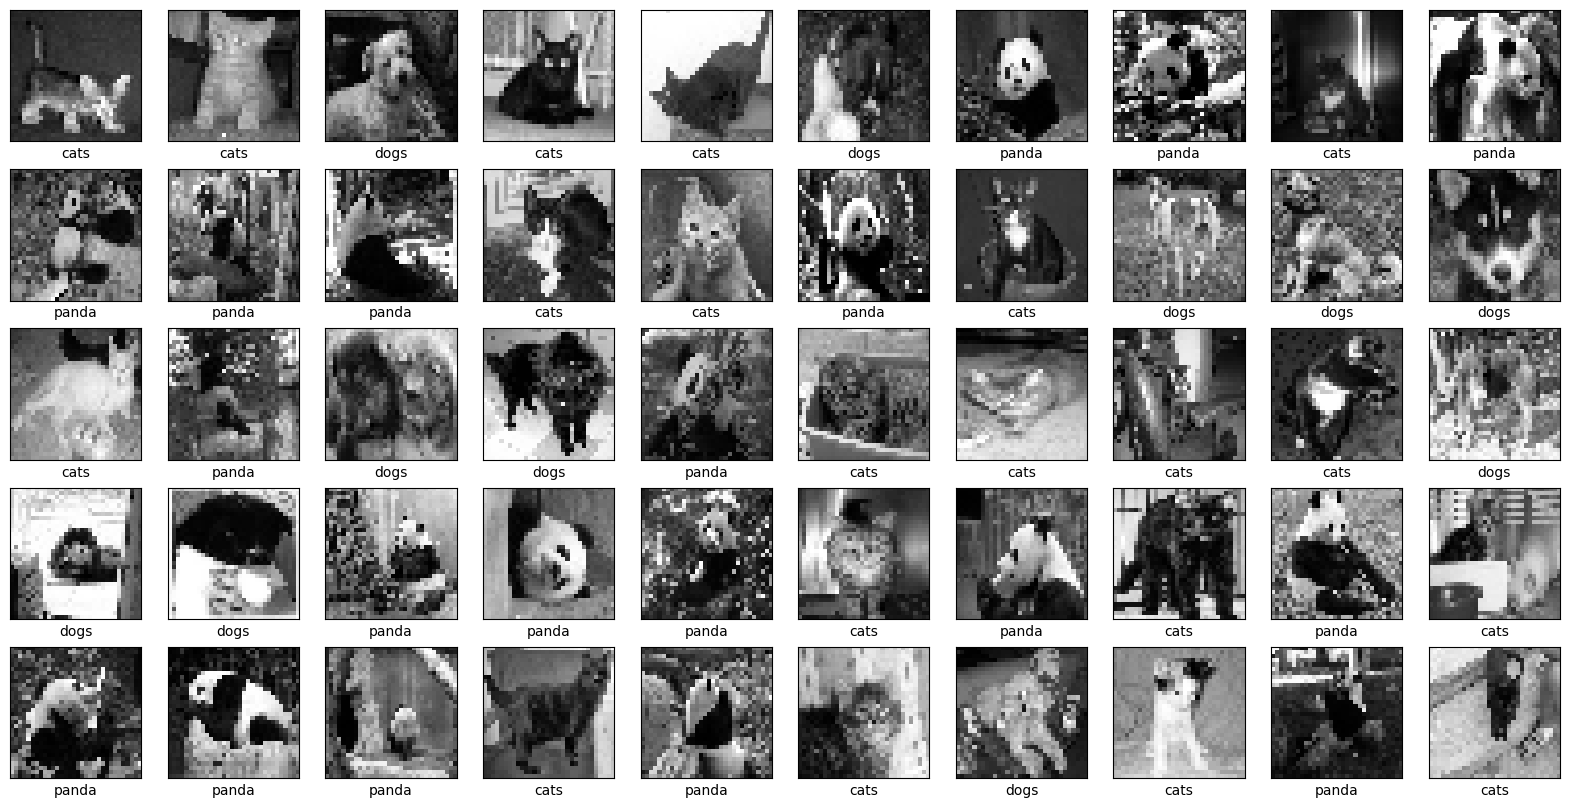

In [5]:
random.shuffle(TRAIN_DATA)
plt.figure(figsize=(20,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    image = TRAIN_DATA[i][0]
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i==50:
        break
plt.show()

# Training

In [6]:
# Dividing the dataset into 5 separate folds
f0 = TRAIN_DATA[0:600]
f1 = TRAIN_DATA[600:1200]
f2 = TRAIN_DATA[1200:1800]
f3 = TRAIN_DATA[1800:2400]
f4 = TRAIN_DATA[2400:3000]

In [7]:
# Functions for collecting l1 & l2 distances respectively
def l1_dist(image1, image2):
    return np.sum(np.abs(image1 - image2))

def l2_dist(image1, image2):
    return np.sqrt(np.sum((image1 - image2) ** 2))

In [8]:
# Defining the metric to sort a list based on it's 3rd index
def by_l1_dist(list):
    return list[2]["l1"]

def by_l2_dist(list):
    return list[2]["l2"]

In [9]:
top_filter = 20

def distance_calc(train_fold, valid_fold):
    l1_result = []
    l2_result = []

    for valid in tqdm(valid_fold):
        temp_dist_list = []

        for train in train_fold:
            l1_distance = l1_dist(valid[0], train[0])
            l2_distance = l2_dist(valid[0], train[0])
            temp_dist_list.append([valid[1],  train[1], {"l1": l1_distance, "l2": l2_distance}])

        temp_dist_list.sort(key=by_l1_dist)
        l1_result.append(temp_dist_list[:top_filter])
        temp_dist_list.sort(key=by_l2_dist)
        l2_result.append(temp_dist_list[:top_filter])

    return [l1_result, l2_result]

In [10]:
k_range = 20

def cal_accuracy(dist_result, dist_term):
    k_accuracies = []

    for k in range(1, k_range+1):
        img_accuracy = 0
        for valid_img in dist_result:
            nn = valid_img[:k]
            same_class = [n for n in nn if n[0] == n[1]]
            same_class_len = len(same_class)

            if k % 2 != 0:
                if ((k-1) / 2) < same_class_len:
                    img_accuracy += 1

            else:
                diff_class = [n for n in nn if n[0] != n[1]]
                if same_class_len > len(diff_class):
                    img_accuracy += 1
                elif same_class_len == len(diff_class): # in case of a tie
                    same_class_dist = sum([n[2][dist_term] for n in same_class])
                    diff_class_dist = sum([n[2][dist_term] for n in diff_class])
                    if same_class_dist > diff_class_dist:
                        img_accuracy += 1

        k_accuracies.append(img_accuracy/len(dist_result))

    return k_accuracies

In [11]:
dist_by_fold = []
import math
for i in range(5):
    if i==0:
        train = f1+f2+f3+f4
        validation = f0
    elif i==1:
        train = f0+f2+f3+f4
        validation = f1
    elif i==2:
        train = f1+f0+f3+f4
        validation = f2
    elif i==3:
        train = f1+f2+f0+f4
        validation = f3
    elif i==4:
        train = f1+f2+f3+f0
        validation = f4

    dist_by_fold.append(distance_calc(train, validation))

100%|██████████| 600/600 [00:41<00:00, 14.44it/s]


In [12]:
len(dist_by_fold[0][0])

600

In [13]:
accuracies = []

for result in dist_by_fold:
    l1_accuracy = cal_accuracy(result[0], "l1")
    l2_accuracy = cal_accuracy(result[1], "l2")
    accuracies.append([l1_accuracy, l2_accuracy])


In [14]:
len(accuracies)

5

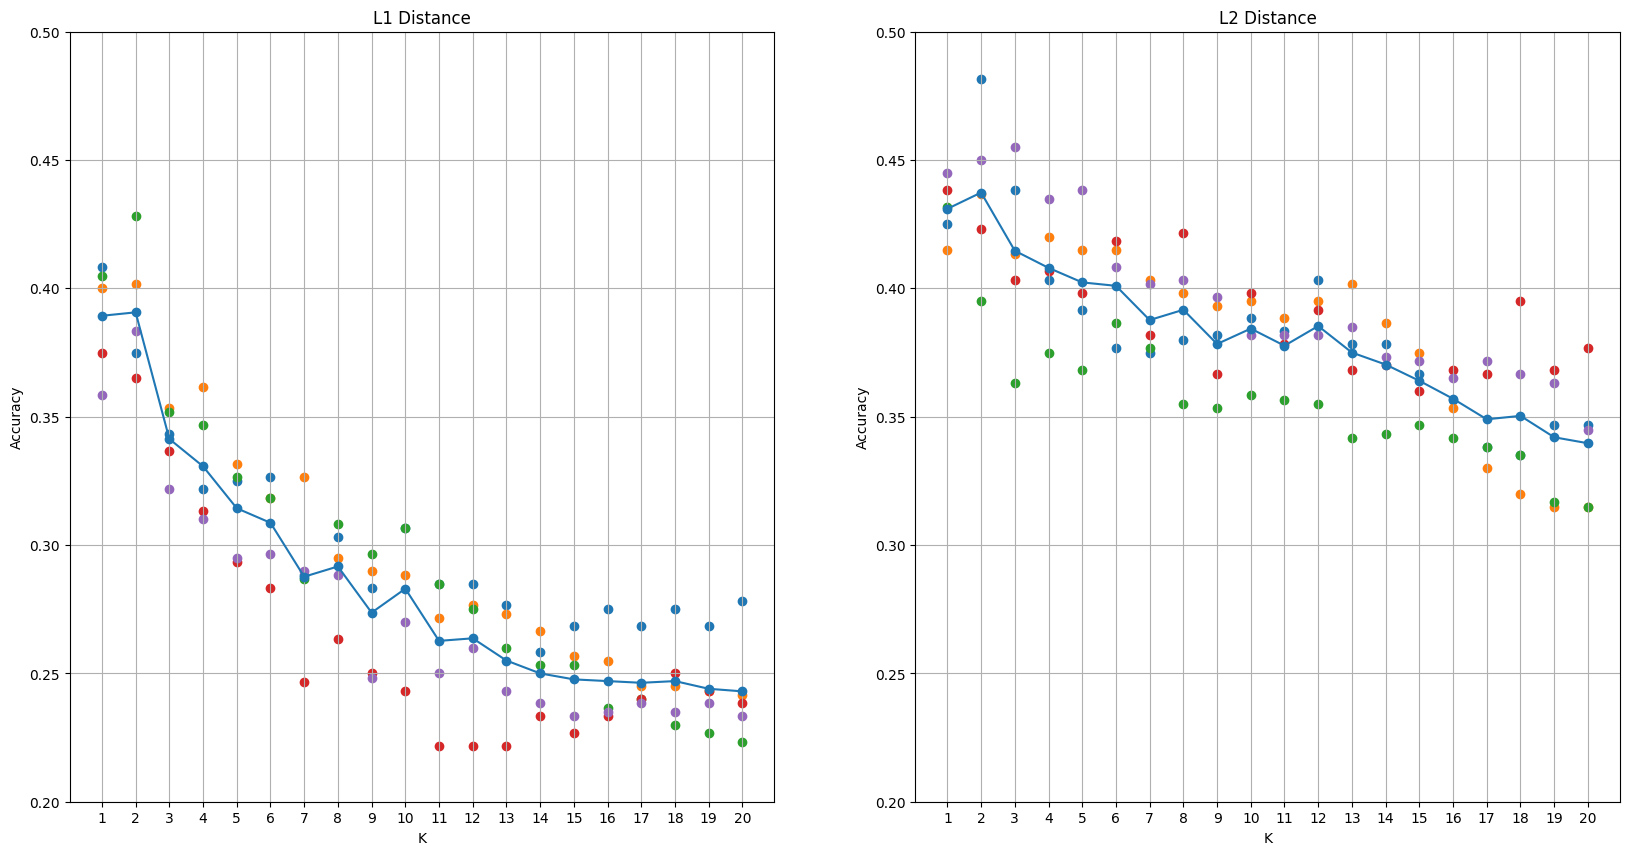

In [15]:
# l1 distance accuracy plot

x_list = list(range(1, k_range+1))

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)

for fold in accuracies:
  y_list = fold[0]
  plt.scatter(x_list, y_list)

arr = []
for i in range(k_range):
  arr.append([fold[0][i] for fold in accuracies])

trend = [np.mean(a) for a in arr]

plt.errorbar(x_list, trend,fmt='-o')
plt.title('L1 Distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.ylim(0.2, 0.5)

# l2 distance accuracy plot
x_list = list(range(1, k_range+1))

plt.subplot(1,2,2)
for fold in accuracies:
  y_list = fold[1]
  plt.scatter(x_list, y_list)

arr = []
for i in range(k_range):
  arr.append([fold[1][i] for fold in accuracies])

trend = [np.mean(a) for a in arr]

plt.errorbar(x_list, trend,fmt='-o')
plt.title('L2 Distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.ylim(0.2, 0.5)
plt.show()

# Discussion

**Accuracy:** In terms distance metrics, we used two, Manhattan (l1) & Euclidian (l2). The former calculates the distances of each points in 2 images and returns the summed total error. The latter does the same but before summing up each individual errors, it squeares them off and then takes the square root of the total sum and the result is the Euclidian error between the images. The accuracy depends of the characteristics of the images and will vary significantly for different datasets. For our short dataset of just 3 classes (3000 total images), the Euclidian distance metric proved better with the highest accuracy reaching 49% when k=2. On the other hand, for Manhattan, the accuracy peaked at 42% when k=1. It is worth mentioning that as the number of nearest neighbors increase, the accuracy drops, it is mainly due to the fact that the chance of ties accuring increases when more neighbors are taken into consideration.



---



**Limitations:** The KNN algorithm is not an actual model, as it simply calculated the distances from a certain point to determin the class of that point. So, for each testing image, the process has to be repeated as there are no weights of biases to save for further use. This makes for higher computation time.



---



**Improvements:** A neural network would work best as it can store the values of thousands of different variables and it will improve both the training and testing time. Since KNN is less accurate when the number of neighbors are fewer, so to get the best possible results, the value of k should be chosen to be as low as needed.

# Predictions

Top 5 Predictions for L1 Distance:
Prediction 1: Class 'dogs' with L1 distance 0.00
Prediction 2: Class 'cats' with L1 distance 725.00
Prediction 3: Class 'cats' with L1 distance 756.17
Prediction 4: Class 'cats' with L1 distance 767.07
Prediction 5: Class 'cats' with L1 distance 769.05

Top 5 Predictions for L2 Distance:
Prediction 1: Class 'dogs' with L2 distance 0.00
Prediction 2: Class 'dogs' with L2 distance 306.01
Prediction 3: Class 'dogs' with L2 distance 308.44
Prediction 4: Class 'cats' with L2 distance 312.07
Prediction 5: Class 'cats' with L2 distance 312.94


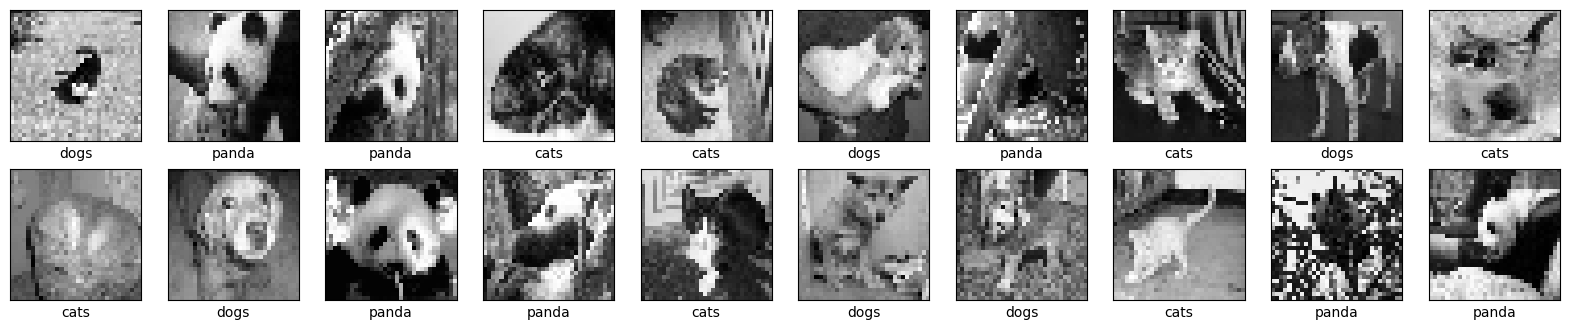

In [16]:
random.shuffle(TRAIN_DATA)

plt.figure(figsize=(20, 10))

for i in range(20):
    plt.subplot(5, 10, i+1)
    image = TRAIN_DATA[i][0]
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i == 19:
        break

test_images = []

for i in range(3000):
    test_image = TRAIN_DATA[i][0]
    test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    test_images.append(test_image_gray)

print("Top 5 Predictions for L1 Distance:")
for test_image_gray in test_images:
    distances1 = []
    for train_image, class_num in TRAIN_DATA:
        train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)
        dist1 = l1_dist(test_image_gray, train_image_gray)
        distances1.append((dist1, class_num))
    distances1.sort(key=lambda x: x[0])

    for i, (dist1, class_num) in enumerate(distances1[:5]):
        predicted_class = CATEGORIES[class_num]
        print(f"Prediction {i+1}: Class '{predicted_class}' with L1 distance {dist1/100:.2f}")
    break

print("\nTop 5 Predictions for L2 Distance:")
for test_image_gray in test_images:
    distances2 = []
    for train_image, class_num in TRAIN_DATA:
        train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)
        dist2 = l2_dist(test_image_gray, train_image_gray)
        distances2.append((dist2, class_num))
    distances2.sort(key=lambda x: x[0])

    for i, (dist2, class_num) in enumerate(distances2[:5]):
        predicted_class = CATEGORIES[class_num]
        print(f"Prediction {i+1}: Class '{predicted_class}' with L2 distance {dist2:.2f}")
    break

Classes with their number of occurances: {'cats': [3, 603.2534287507914]}
max number of at common class: 3
highest probable class: ['cats']


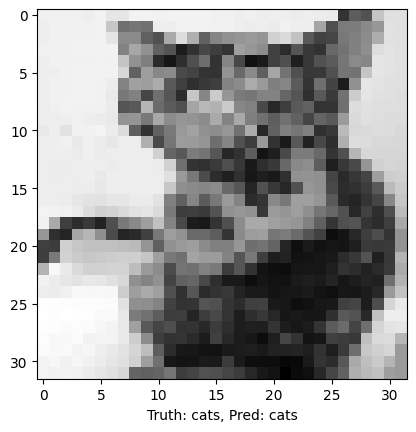



Classes with their number of occurances: {'dogs': [2, 314.2864935055275], 'cats': [1, 314.80152477394387]}
max number of at common class: 2
highest probable class: ['dogs']


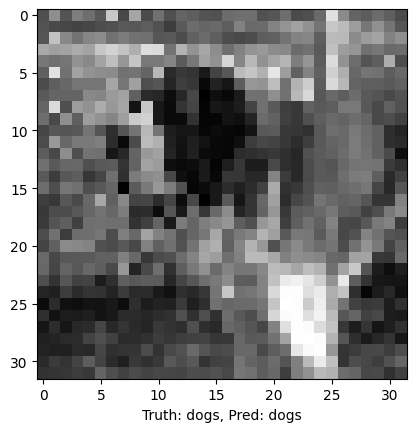



Classes with their number of occurances: {'dogs': [3, 623.8811609606536]}
max number of at common class: 3
highest probable class: ['dogs']


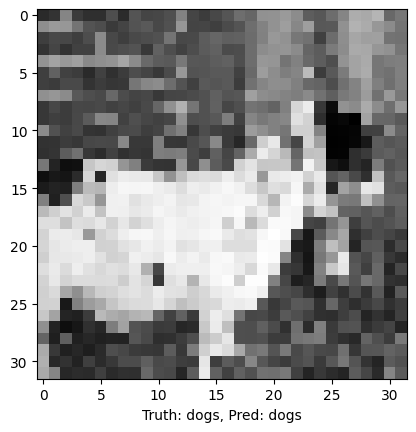



Classes with their number of occurances: {'cats': [2, 305.60431934120305], 'dogs': [1, 307.0423423568808]}
max number of at common class: 2
highest probable class: ['cats']


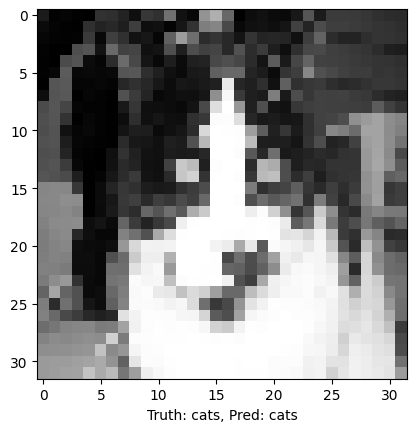



Classes with their number of occurances: {'cats': [3, 621.6757349557134]}
max number of at common class: 3
highest probable class: ['cats']


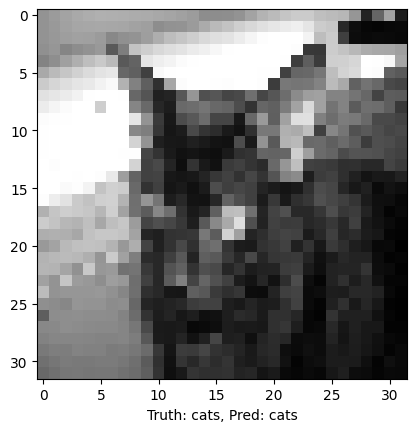



Classes with their number of occurances: {'dogs': [1, 0.0], 'cats': [1, 295.6349099818897], 'panda': [1, 299.7215374309961]}
max number of at common class: 1
highest probable class: ['dogs', 'cats', 'panda']
Class with the least error: (['dogs'], 0.0)


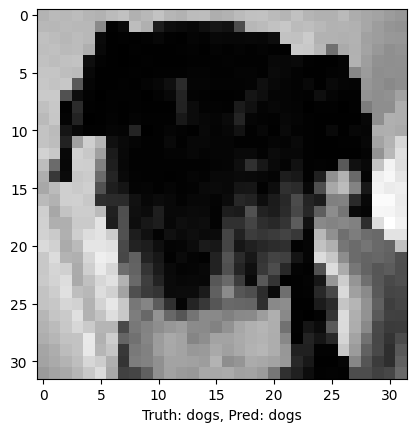



Classes with their number of occurances: {'dogs': [1, 0.0], 'cats': [2, 616.6619819300723]}
max number of at common class: 2
highest probable class: ['cats']


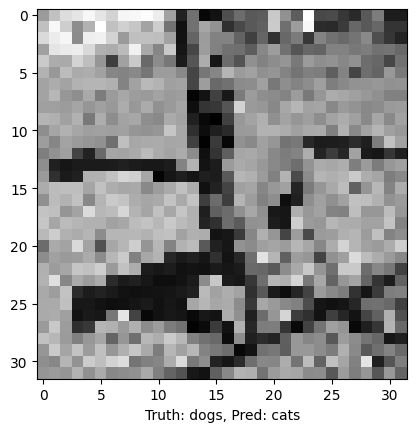



Classes with their number of occurances: {'dogs': [1, 0.0], 'panda': [1, 308.79928756394503], 'cats': [1, 308.82681230748085]}
max number of at common class: 1
highest probable class: ['dogs', 'panda', 'cats']
Class with the least error: (['dogs'], 0.0)


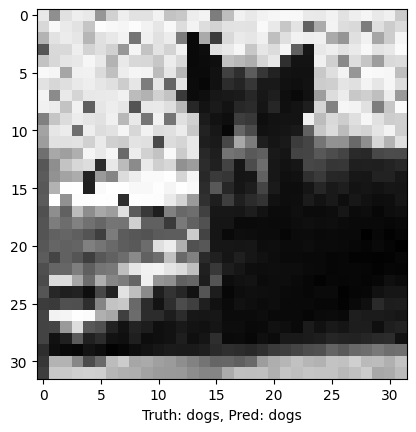



Classes with their number of occurances: {'dogs': [2, 311.3229834111192], 'cats': [1, 311.77876771839357]}
max number of at common class: 2
highest probable class: ['dogs']


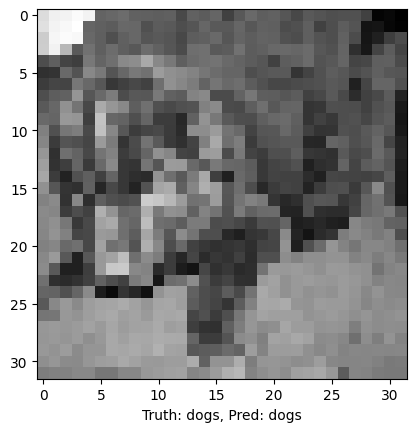



Classes with their number of occurances: {'cats': [1, 0.0], 'dogs': [2, 620.36115884645]}
max number of at common class: 2
highest probable class: ['dogs']


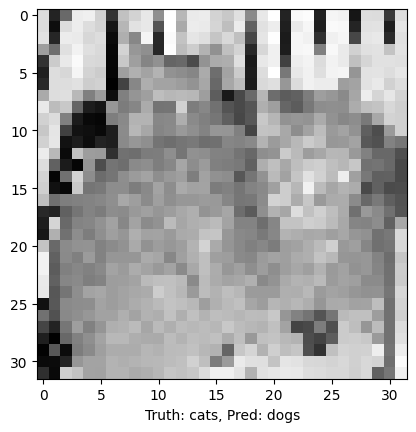



Classes with their number of occurances: {'cats': [3, 595.1650522839213]}
max number of at common class: 3
highest probable class: ['cats']


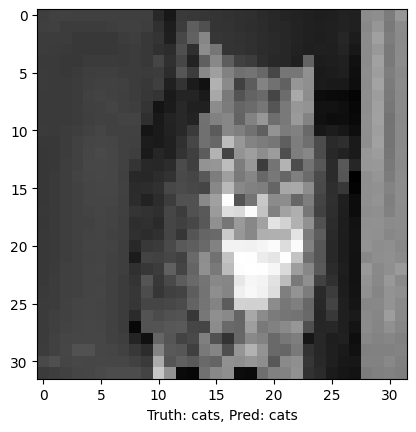



Classes with their number of occurances: {'panda': [1, 0.0], 'cats': [2, 617.8106717143446]}
max number of at common class: 2
highest probable class: ['cats']


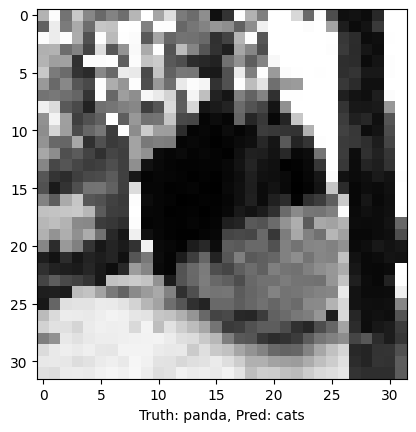



Classes with their number of occurances: {'cats': [3, 607.22465341252]}
max number of at common class: 3
highest probable class: ['cats']


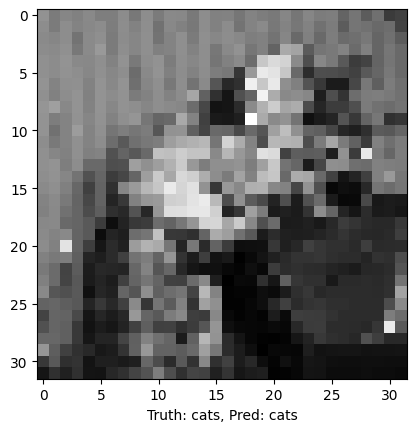



Classes with their number of occurances: {'cats': [1, 0.0], 'dogs': [2, 613.355847123072]}
max number of at common class: 2
highest probable class: ['dogs']


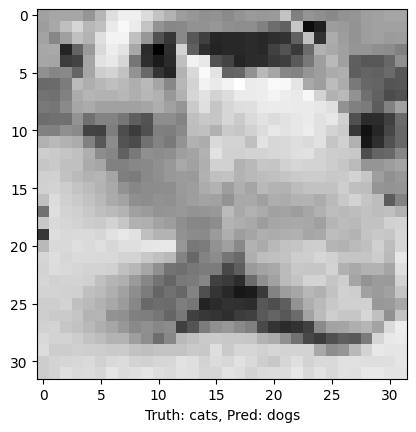



Classes with their number of occurances: {'cats': [2, 310.9598044763985], 'panda': [1, 310.6831183054528]}
max number of at common class: 2
highest probable class: ['cats']


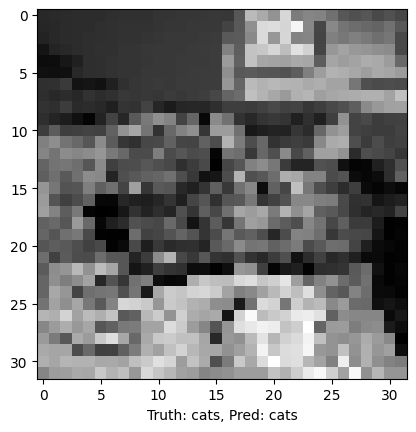



Classes with their number of occurances: {'dogs': [1, 0.0], 'cats': [2, 623.4259853037518]}
max number of at common class: 2
highest probable class: ['cats']


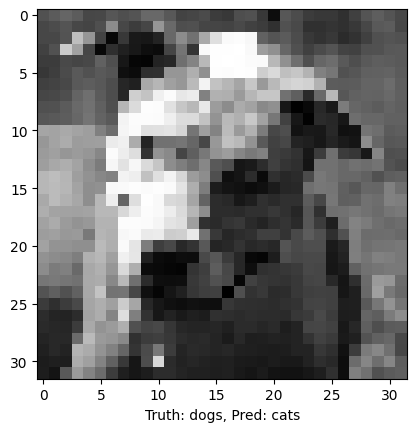



Classes with their number of occurances: {'panda': [1, 0.0], 'cats': [2, 592.7409387885574]}
max number of at common class: 2
highest probable class: ['cats']


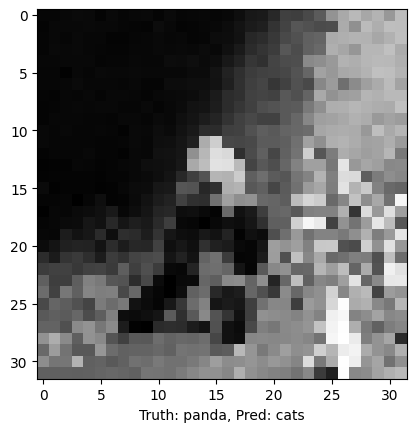



Classes with their number of occurances: {'cats': [1, 0.0], 'dogs': [1, 310.19671178141135], 'panda': [1, 310.4995974232495]}
max number of at common class: 1
highest probable class: ['cats', 'dogs', 'panda']
Class with the least error: (['cats'], 0.0)


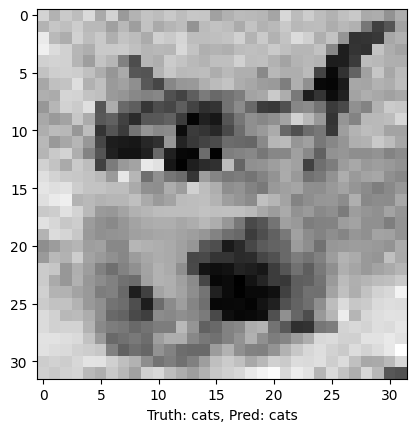



Classes with their number of occurances: {'cats': [3, 576.1086435208651]}
max number of at common class: 3
highest probable class: ['cats']


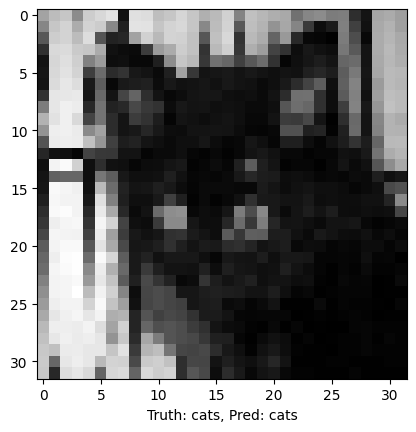



Classes with their number of occurances: {'cats': [2, 299.81160751378525], 'dogs': [1, 307.52886043426884]}
max number of at common class: 2
highest probable class: ['cats']


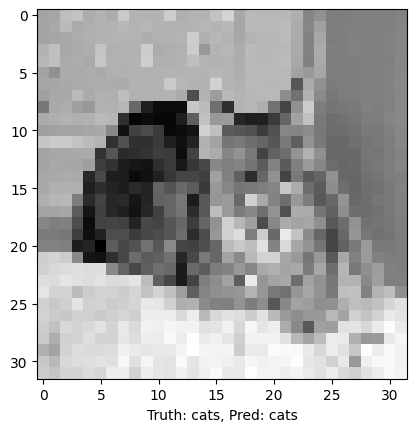



Classes with their number of occurances: {'panda': [1, 0.0], 'dogs': [1, 299.87830865202636], 'cats': [1, 302.3739406761105]}
max number of at common class: 1
highest probable class: ['panda', 'dogs', 'cats']
Class with the least error: (['panda'], 0.0)


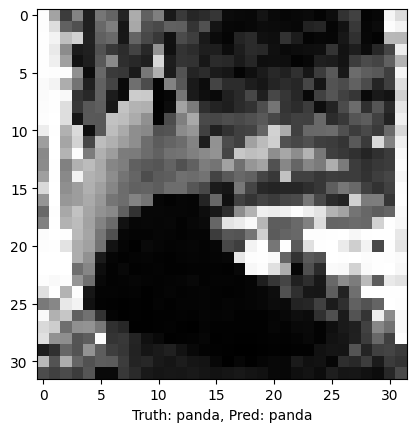



Classes with their number of occurances: {'dogs': [1, 0.0], 'panda': [1, 307.421534704386], 'cats': [1, 308.54497241083027]}
max number of at common class: 1
highest probable class: ['dogs', 'panda', 'cats']
Class with the least error: (['dogs'], 0.0)


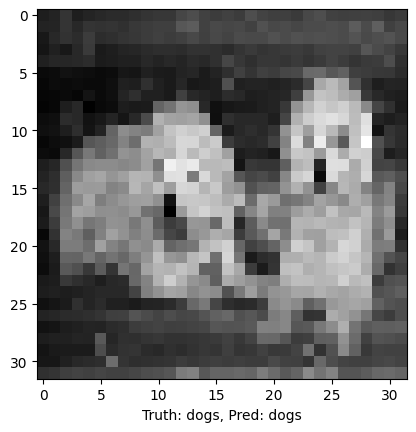



Classes with their number of occurances: {'panda': [3, 628.2976553835556]}
max number of at common class: 3
highest probable class: ['panda']


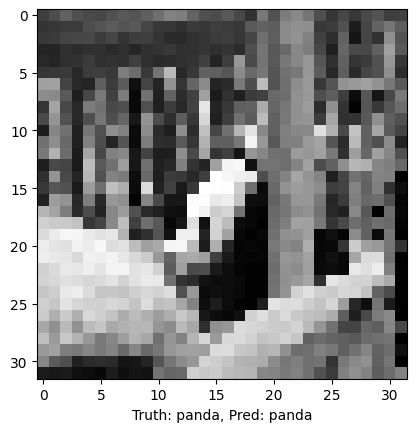



Classes with their number of occurances: {'dogs': [2, 310.9887457770779], 'cats': [1, 312.0304472323174]}
max number of at common class: 2
highest probable class: ['dogs']


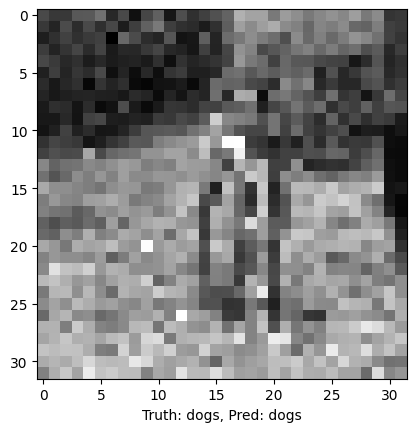



Classes with their number of occurances: {'cats': [2, 314.6283521871479], 'panda': [1, 310.2337828154761]}
max number of at common class: 2
highest probable class: ['cats']


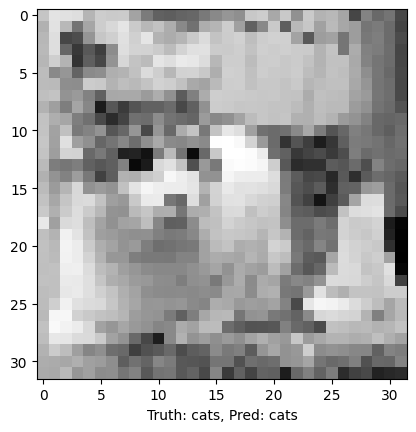



Classes with their number of occurances: {'panda': [1, 0.0], 'cats': [2, 624.8998700103825]}
max number of at common class: 2
highest probable class: ['cats']


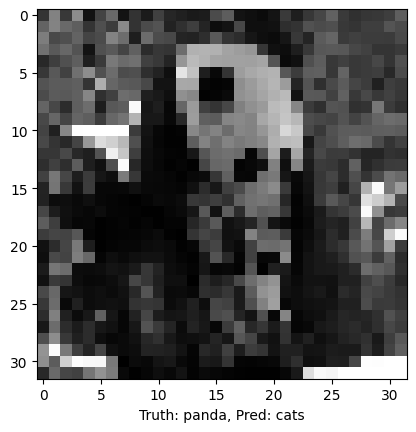



Classes with their number of occurances: {'dogs': [2, 313.8725856139717], 'cats': [1, 311.2940731848263]}
max number of at common class: 2
highest probable class: ['dogs']


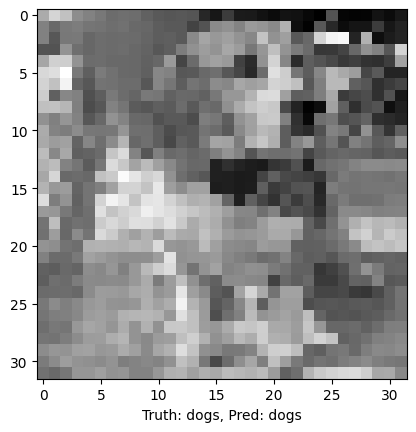



Classes with their number of occurances: {'panda': [2, 312.924911120863], 'dogs': [1, 312.27551937351734]}
max number of at common class: 2
highest probable class: ['panda']


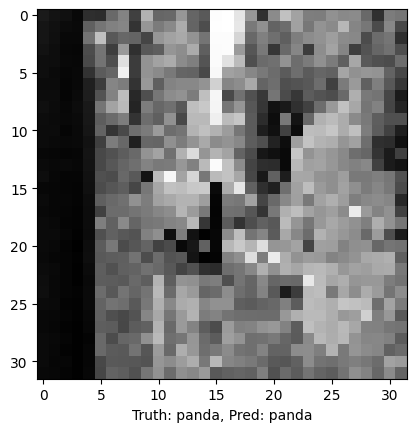



Classes with their number of occurances: {'dogs': [1, 0.0], 'cats': [2, 582.0419263862195]}
max number of at common class: 2
highest probable class: ['cats']


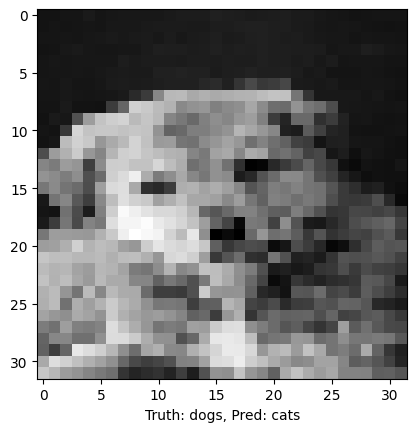



Classes with their number of occurances: {'panda': [1, 0.0], 'cats': [2, 611.9774944255914]}
max number of at common class: 2
highest probable class: ['cats']


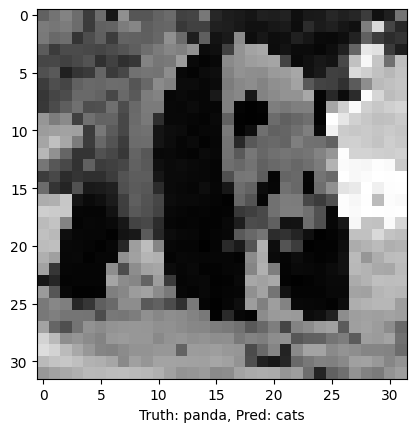



Classes with their number of occurances: {'dogs': [1, 0.0], 'cats': [2, 593.4235537003874]}
max number of at common class: 2
highest probable class: ['cats']


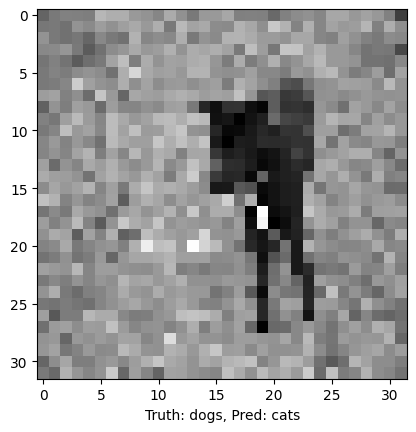



Classes with their number of occurances: {'dogs': [1, 0.0], 'cats': [2, 624.2403202428559]}
max number of at common class: 2
highest probable class: ['cats']


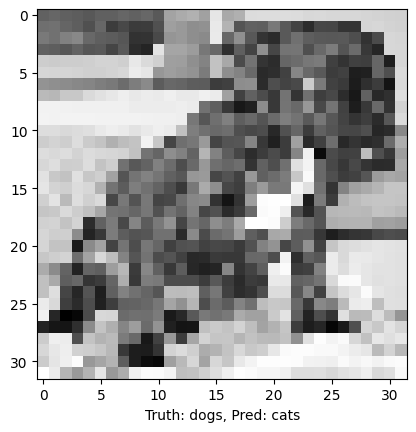



Classes with their number of occurances: {'panda': [1, 0.0], 'cats': [2, 628.8274796640383]}
max number of at common class: 2
highest probable class: ['cats']


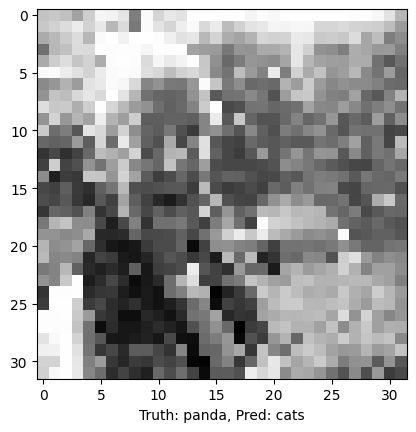



Classes with their number of occurances: {'dogs': [3, 626.616263081708]}
max number of at common class: 3
highest probable class: ['dogs']


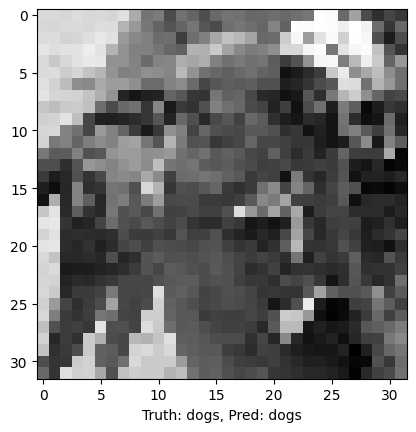



Classes with their number of occurances: {'panda': [1, 0.0], 'dogs': [2, 598.0799688802297]}
max number of at common class: 2
highest probable class: ['dogs']


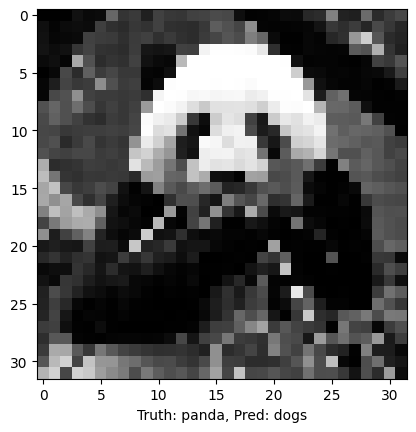



Classes with their number of occurances: {'cats': [2, 307.13514940494844], 'panda': [1, 301.713440204443]}
max number of at common class: 2
highest probable class: ['cats']


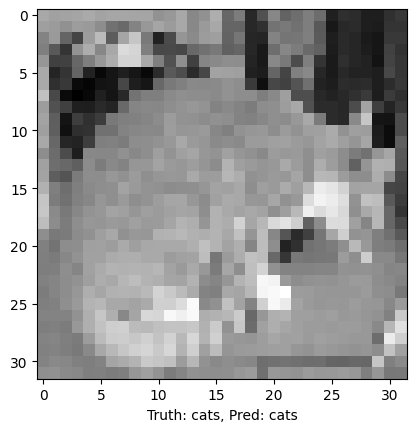



Classes with their number of occurances: {'panda': [1, 0.0], 'cats': [1, 312.064095980297], 'dogs': [1, 312.48679972120425]}
max number of at common class: 1
highest probable class: ['panda', 'cats', 'dogs']
Class with the least error: (['panda'], 0.0)


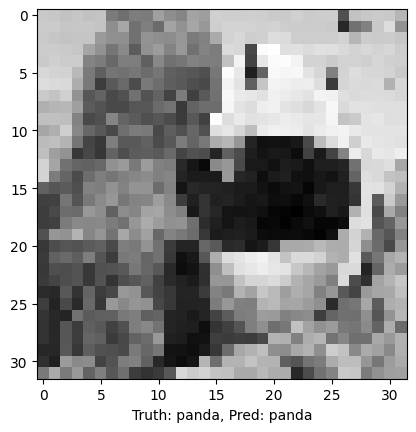



Classes with their number of occurances: {'dogs': [1, 0.0], 'cats': [1, 314.42805218364344], 'panda': [1, 314.6617231250093]}
max number of at common class: 1
highest probable class: ['dogs', 'cats', 'panda']
Class with the least error: (['dogs'], 0.0)


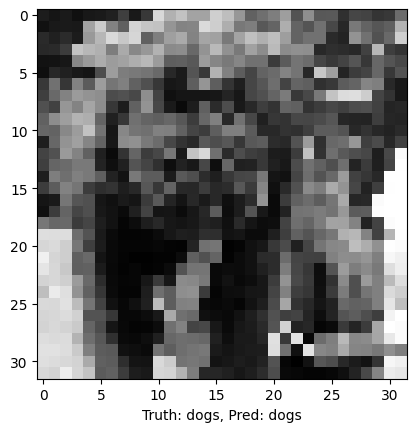



Classes with their number of occurances: {'dogs': [1, 0.0], 'cats': [2, 623.9806892416971]}
max number of at common class: 2
highest probable class: ['cats']


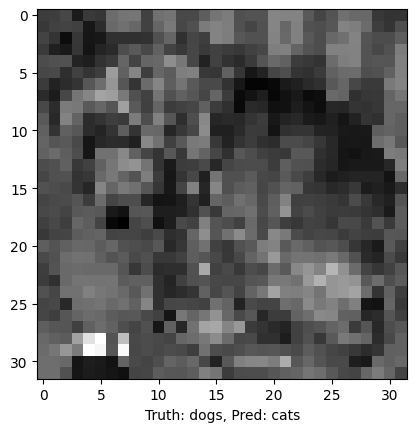



Classes with their number of occurances: {'panda': [3, 625.414165425306]}
max number of at common class: 3
highest probable class: ['panda']


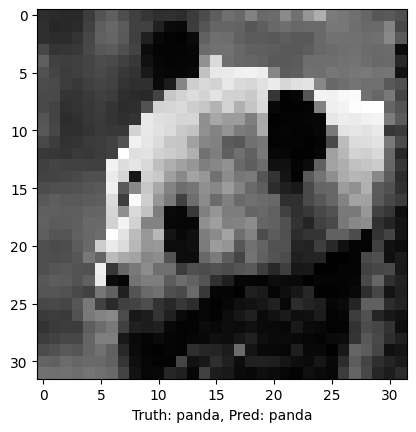



Correctly predicted 26 images out of 40, overall accuracy: 65.0 %


In [20]:
random.shuffle(TRAIN_DATA)

test_images = []
neighbours = 3
test_count = 40

for i in range(test_count):
    test_image = TRAIN_DATA[i][0]
    test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    test_images.append([test_image_gray, TRAIN_DATA[i][1]])

accurate = 0

for test_image_gray in test_images:
    distances2 = []
    pred = None
    for train_image, class_num in TRAIN_DATA:
        train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)
        dist2 = l2_dist(test_image_gray[0], train_image_gray)
        distances2.append((dist2, class_num))
    distances2.sort(key=lambda x: x[0])

    prediction_classes = [[cl[0], CATEGORIES[cl[1]]] for cl in distances2[:neighbours]]
    occurrences_dict = {pc[1]: [0,0] for pc in prediction_classes}
    for pc in prediction_classes:
      if pc[1] in occurrences_dict:
          occurrences_dict[pc[1]][0] = occurrences_dict[pc[1]][0] + 1
          occurrences_dict[pc[1]][1] += pc[0]
      else:
          occurrences_dict[pc[1]][0] = 1
          occurrences_dict[pc[1]][1] += pc[0]

    print(f'Classes with their number of occurances: {occurrences_dict}')

    elements_at_index_0 = [value[0] for value in occurrences_dict.values()]
    max_count_0 = max(elements_at_index_0)
    print(f'max number of at common class: {max_count_0}')

    keys_with_max_value = [key for key, value in occurrences_dict.items() if value[0] == max_count_0]
    print(f'highest probable class: {keys_with_max_value}')

    if len(keys_with_max_value) == 1:
      pred = keys_with_max_value[0]
    else:
      elements_at_index_1 = [value[1] for value in occurrences_dict.values()]
      min_count_1 = min(elements_at_index_1)

      keys_with_min_value = [key for key, value in occurrences_dict.items() if value[1] == min_count_1]
      pred = keys_with_min_value[0]
      print(f'Class with the least error: {keys_with_min_value, min_count_1}')

    #print(pred)

    truth = CATEGORIES[test_image_gray[1]]
    plt.figure()
    plt.imshow(test_image_gray[0], cmap="gray")
    plt.xlabel(f"Truth: {truth}, Pred: {pred}")
    plt.show()
    if truth == pred: accurate += 1
    for i in range(2): print()


    #break

print(f'Correctly predicted {accurate} images out of {test_count}, overall accuracy: {(accurate/test_count)*100} %')